<a href="https://colab.research.google.com/github/bimewok/Strava-Classifier/blob/main/Strava_Activity_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Strava Activity Classifier

**Author:** [Ben Garrett](https://github.com/bimewok)<br>
**Date created:** 2020-10-23<br>
**Last modified:** 2020-12-17<br>
**Description:** Comparisons, tuning and ensembling of various classification models to solve a real-world problem

# Introduction

The athlete social networking and activity tracking app Strava has been getting lots of attention lately due to its $1B+ valueation in a 2020 round of funding. The app reports at least 70M active users, growing by over 1M users per month. The service provides a platform for users to record and share their activities with their followers of community groups. The service can be connected to virtually all existing fitness tracking devices, providing a centralized place for an athlete to store an archive of their activities and try to improve from it.<br>
<br>
As a Strava user since 2019, I have logged around 400 activities ranging from hikes, road bike rides, mountain bike rides, runs, river float trips, ski outings, snowshoeing and probably a few other random activities I am forgetting. In this project, I will prototype a machine learning pipeline to help improve the user experience in the app. <br>


### The Problem:

When you record an activity using the app, the app asks the user what activity type (run, hike, ride, ect.) they want to classify the aactivity as. How annoying! Wouldn't it be nice if the app 'knew' what I want to classify my activity as?

<img src="https://github.com/bimewok/Strava-Classifier/blob/main/img/Screenshot1.png?raw=true" width="240" height="506" align="right"/>

### Constraints:

The end product needs to be a model that can be run on live data onboard the user's smartphone. Thus, the model should ideally be lightweight and quick. The model can be trained / batch updated using powerful computers, but at time of inference, the model needs to be speedy. 

### The Data:

The way the app is currently set up, a user hits 'record' and goes about their activity. After they are done, the app asks them to choose the activity type what they had just recorded. Thus, at time of inference, the model could have access to all of the metrics from their activity that the app recorded, as well as supplimental information pulled in from parallel, live data sources (i.e. weather). In this project, I will be using some basic metrics from all of my activities that I extracted from my Strava account. In reality, Strava likely has more data including accelerometer data which may further improve predictions.



<br>

### Hypothesis, Strategy, Domain Knowledge:

At first thought, this may seem like a simple problem to solve. Run's are faster than hikes which are slower than bike rides. The problem is, each user has a different run speed, hike speed, and bike speed. For example, some of my runs have faster average speeds than my mountain bike rides where I spend more time slowly pedaling uphill than going fast. Additionally, I often do some running in my hikes and some hiking in my trail runs. Thus, I want the end product to classify an activity based on what the user wants it calssified as, not what the activity actually was. For example, I recently went on a 20 mile train run / mountain climbing endevour that involved slow, off-trail climbing as well as many miles of fast trail running. Even though I spent more time hiking than running, I want the activity classified as a run. Thus, I want the tool to make its decision based on any user's history, not the whole social network. I don't want the tool to subtly discourage anybody getting into running by calssifying a slow run as a hike or walk!

Based on a reflection of my own excersize patterns, I think the most relevant information to train the model is: average speed, total duration, percent of total duration not moving, elevation gain, starting hour, day of the week and day of the year. Additionally, I think it may be helpful to pull in weather data as the temperature, wind and rain definitely impact what activity I will engage in on a given day. In similar problems, random forest, support vector machine, and logistic regression models oftem perform well and run quick at inference time. Thus, they should be tested. 

In my proffessional opinion, the end product needs to achieve an overall accuracy of 90% or better to be implementable. Ideally the model will be able to output a probability for each classification so the system can be designed to refrain from making a bad classification when it isn't confident. 

Strategy:<br>
- get the activity and weather data<br>
- explore and visualize the data<br>
- clean data / feature engineereing<br>
- build baseline model(s) <br>
- select some models to tune<br>
- consider ensembling tuned models<br>
- evaluate final model on test data<br>
- make some predictions!




## Imports


In [ ]:
import pandas as pd
import os
from datetime import datetime
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, LeaveOneOut, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier, VotingClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.pipeline import Pipeline
import numpy as np
import copy
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from joblib import dump, load
from math import pi
import seaborn as sns
import requests
import io
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)

pd.set_option('display.expand_frame_repr', False)
print('Ready to go!')

Ready to go!


## Weather Data

In this project, we will use NOAA GHCND daily summary data for the analysis. In the final product, this dataset will not be appropriate since the daily sumary data is not available in real time. The final product will need to find a realtime weather source to use for inference. 
The data can be found here: https://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND

**Location**: The majority of my activites happen in and around Missoula, Montana, thus I downloaded data for the Missoula International Airport weather station. However, if a real-time weather source is linked to the model at inference time, you could likely fine-tune the weather data to the closest station to the activity starting point for better accuracy. 

**Time-frame Considered**: Jul 20, 2016 - Oct 15, 2020<br>
Although I have some data from as far back as 2016, these were just gps tracks I happen to have saved locally. I didn't start tracking activities regularly until mid-2019


The GHCND data:<br>
<br>
*note: according to NOAA, the data should be in all metric units but the data I downloaded appears to be imperial.

| **Features** | **Dtype**  | **Description**                                                        |
| ------------ | ---------- | ---------------------------------------------------------------------- |
| STATION      | string     | station ID                                                             |
| NAME         | string     | name of station                                                        |
| DATE         | 2018-01-02 | Date (1 obs. / day)                                                    |
| AWND         | float      | Average daily wind speed (mph)                                         |
| PGTM         | null       | Peak gust time (hours and minutes, i.e., HHMM)                         |
| PRCP         | float      | Precipitation (inches)                                                 |
| SNOW         | float      | Snowfall (inches)                                                      |
| SNWD         | float      | Snow depth (inches)                                                    |
| TAVG         | int        | daily mean temp. (F)                                                   |
| TMAX         | int        | daily max temp. (F)                                                    |
| TMIN         | int        | daily min temp. (F)                                                    |
| WDF2         | int        | Direction of fastest 2-minute wind (degrees)                           |
| WDF5         | int        | Direction of fastest 5-second wind (degrees)                           |
| WSF2         | float      | Fastest 2-minute wind speed (tenths of meters per second)              |
| WSF5         | float      | Fastest 5-second wind speed (tenths of meters per second)              |
| WT01         | binary int | Fog, ice fog, or freezing fog (may include heavy fog)                  |
| WT02         | binary int | Heavy fog or heaving freezing fog (not always distinguished from fog)  |
| WT03         | binary int | Thunder                                                                |
| WT04         | binary int | Ice pellets, sleet, snow pellets, or small hail                        |
| WT05         | binary int | Hail (may include small hail)                                          |
| WT06         | binary int | Glaze or rime                                                          |
| WT08         | binary int | Dust, volcanic ash, blowing dust, blowing sand, or blowing obstruction |
| WT09         | binary int | Smoke or haze                                                          |

## Strava Data

For those with a Strava account, you can download your data here: https://www.strava.com/athlete/delete_your_account


The data download contains a spreadsheet with all of the non-spatial activity metrics recorded by the app. I have trimmed off a few sensative features in the data I am providing here (like heart rate data). In a final product, this information could be utilized to possible achieve better model performance. 


The data:

| **Features**   | **Dtype**           | **Description**                                                                                                |
| -------------- | ------------------- | -------------------------------------------------------------------------------------------------------------- |
| Activity Date  | Mar 9, 2019 6:20 PM | date and time of beginning of activity                                                                         |
| Activity Name  | string              | activity name (may be user created or autogenerated)                                                           |
| Activity ID    | int                 | unique ID for activity                                                                                         |
| Type           | string              | activity type (run, hike, bike)                                                                                |
| Equipment      | null                | user can specify what they used during activity                                                                |
| Distance       | float               | miles                                                                                                          |
| Total Time     | 00:56:58            | duration of activity                                                                                           |
| Moving Time    | 00:15:30            | moving time                                                                                                    |
| Avg Speed      | float               | avg moving speed, mph                                                                                          |
| Max Speed      | float               | max speed, mph                                                                                                 |
| Avg Power      | float               | Strava estimates avg watt output for bike rides. This is only available after the activity has been classified |
| Elevation Gain | int                 | feet                                                                                                           |
| Avg Grade      | float               | cannot find units anywhere                                                                                     |
| Kudos          | int                 | number of ‘likes’ from other users. Not available at runtime                                                   |
| Comments       | int                 | number of comments from other users. Not available at runtime                                                  |
| Photos         | int                 | number of user uploaded photos. May or may not be available depending on user behavior                         |
| Riders         | int                 | number of Strava users who participated in activity. Not available at runtime                                  |
| Commute        | binary string       | Did user classify activity as commute. May or may not be available depending on user behavior                  |
| Trainer        | binary string       | Unsure what this feature means                                                                                 |
| Description    | string              | User uploaded description of activity                                                                          |


## Get the data

In [ ]:
activities_path = 'https://raw.githubusercontent.com/bimewok/Strava-Classifier/main/data/ActivityDetails.csv'
weather_path = 'https://raw.githubusercontent.com/bimewok/Strava-Classifier/main/data/weather.csv'

def get_data(activities_path, weather_path):
    # load my raw strava data
    activities = requests.get(activities_path).content
    weather = requests.get(weather_path).content

    activity_details = pd.read_csv(io.StringIO(activities.decode('utf-8')))
    weather = pd.read_csv(io.StringIO(weather.decode('utf-8')))
    # drop some of the columns that don't seem super relevant
    weather = weather[['DATE', 'AWND', 'PRCP', 'TAVG', 'TMIN']]
    # we need a field to join the tables on; year_day_of_year
    weather['DATE']= pd.to_datetime(weather['DATE'])
    weather['day_of_year'] = weather['DATE'].dt.dayofyear
    weather['year'] = weather['DATE'].dt.year
    weather['date_join'] = weather['year'].astype(str) + weather['day_of_year'].astype(str)
    # make same field in activity dataset
    activity_details['Activity Date']= pd.to_datetime(activity_details['Activity Date'])
    activity_details['day_of_year'] = activity_details['Activity Date'].dt.dayofyear
    activity_details['year'] = activity_details['Activity Date'].dt.year
    activity_details['date_join'] = activity_details['year'].astype(str) + activity_details['day_of_year'].astype(str)
    # join matching records of the weather and activity activity_detailssets into one activity_details dataframe
    activity_details = pd.merge(activity_details, weather, how="left", on=["date_join"])
    # drop the activity types with few examples; probably can't make meaningful predictions in this category
    indexNames = activity_details[ (activity_details['Type'] != 'Run') & (activity_details['Type'] != 'Ride') & (activity_details['Type'] != 'Hike') ].index
    activity_details.drop(indexNames , inplace=True)
    #shuffle the dataframe
    activity_details = activity_details.sample(frac=1, random_state=42)
    return activity_details

data = get_data(activities_path, weather_path)

print(data.head(5))

          Activity Date Activity Name  Activity ID  Type  Equipment  Distance Total Time Moving Time  Avg Speed  Max Speed  Avg Power  Elevation Gain  Avg Grade  Kudos  Comments  Photos  Riders  Commute Trainer Description  day_of_year_x  year_x date_join       DATE  AWND  PRCP  TAVG  TMIN  day_of_year_y  year_y
175 2019-12-23 10:00:00   Morning Run   2952293445   Run        NaN      0.39   00:04:43    00:04:23        5.3        6.9        0.0              59      152.6      0         0       0       1      NaN     NaN         NaN            357    2019   2019357 2019-12-23  2.24  0.02  33.0    27            357    2019
37  2019-03-20 18:55:00   Evening Run   3388553646   Run        NaN      4.02   00:39:40    00:39:32        6.1       10.7        0.0             120       29.9      0         0       0       1      NaN     NaN         NaN             79    2019    201979 2019-03-20  1.34  0.00  35.0    19             79    2019
15  2018-10-11 12:36:00    Lunch Hike   3388549698  Hike  

## Split the data

Before doing anything, we will split the data into training and test sets. I choose a test size of 25% of total samples. 

In [ ]:
def split_data_(data, test_ratio_):
    #get rid of unneeded features in x, map the activity types to integers
    x = data.drop(['Type', 'Activity Name', 'Activity ID'], axis=1)
    y = data['Type'].map({'Run': 0, 'Ride': 1, 'Hike': 2})
    #split the full dataframe into test and train sets, set stratify to category names to reduce chance of class imbalance in resulting split
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=test_ratio_, stratify=y)
    return x_train, y_train.values, x_test, y_test

x_train, y_train, x_test, y_test = split_data_(data, 0.25) 

## Clean Data
The dataset includes many null values that will break the models as well as many features that won't be available at inference time. Time to do some data cleaning! 

In [ ]:

def clean_data(data):
    cleaned = copy.copy(data)
    # create a day of week column. This may impact activity type
    cleaned.loc[:,'day_of_week'] = cleaned['Activity Date'].dt.dayofweek
    # create a begin hour of activity column. This may impact activity type
    cleaned.loc[:,'hour'] = cleaned['Activity Date'].dt.hour
    # these columns are very sparse and some of them are generated after the app user specifies activity type
    cleaned = cleaned.drop(['Activity Date', 'Commute', 'Trainer', 'Description', 'Comments', 'Equipment', 'Riders', 'Avg Power', 'day_of_year_x', 'DATE', 'date_join', 'year_x'], axis=1)
    # calculate a floating point field for activity duration and percent of activity not moving
    cleaned.loc[:,'Total Time'] = pd.to_datetime(cleaned['Total Time'], format='%H:%M:%S')
    cleaned.loc[:,'Total Time'] = (pd.to_timedelta(cleaned['Total Time'] - datetime(1900, 1, 1)).dt.total_seconds() / 60) / 60
    cleaned.loc[:,'Moving Time'] = pd.to_datetime(cleaned['Moving Time'], format='%H:%M:%S')
    cleaned.loc[:,'Moving Time'] = (pd.to_timedelta(cleaned['Moving Time'] - datetime(1900, 1, 1)).dt.total_seconds() / 60) / 60
    cleaned.loc[:,'stopped_pct']  = (cleaned['Total Time'] - cleaned['Moving Time']) / cleaned['Total Time']
    cleaned = cleaned.drop('Moving Time', axis=1)
    # you can add photos and recieve kudos after the activity type is chosen, thus we need to drop these
    cleaned = cleaned.drop(['Photos', 'Kudos'], axis=1)
    # deal with nulls. if average temp is missing, fill it with min. temp + 12 degress. 
    cleaned['AWND'] = cleaned['AWND'].fillna(2)
    cleaned.loc[:,'TAVG'] = cleaned['TAVG'].fillna(cleaned['TMIN'] + 12)
    
    # keeping cyclical time fields as regular integers means the model will assume day 1 is very far from day 7 of the week, or day 365 of the year, even though they are close
    # this maps the cycles to sine and cosine waves.
    cleaned['day_of_week_cos'] = np.cos(cleaned['day_of_week']*(2.*np.pi/7))
    cleaned['day_of_week_sin'] = np.sin(cleaned['day_of_week']*(2.*np.pi/7))
    cleaned['day_of_year_cos'] = np.cos(cleaned['day_of_year_y']*(2.*np.pi/365))
    cleaned['day_of_year_sin'] = np.sin(cleaned['day_of_year_y']*(2.*np.pi/365))
    
    cleaned = cleaned.drop(['day_of_week', 'day_of_year_y'], axis=1)
    return cleaned

x_train_cleaned = clean_data(x_train)
x_test_cleaned = clean_data(x_test)


## Visualization

Its normally a good idea to do your in-depth visualization on just your training data to prevent any information transfer between the test data and the training dataset. In this case, due to small dataset size, I have chosen to visualize the whole dataset to make the visualizations more meaningful. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


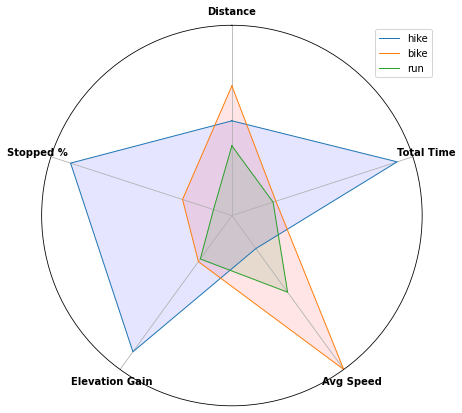

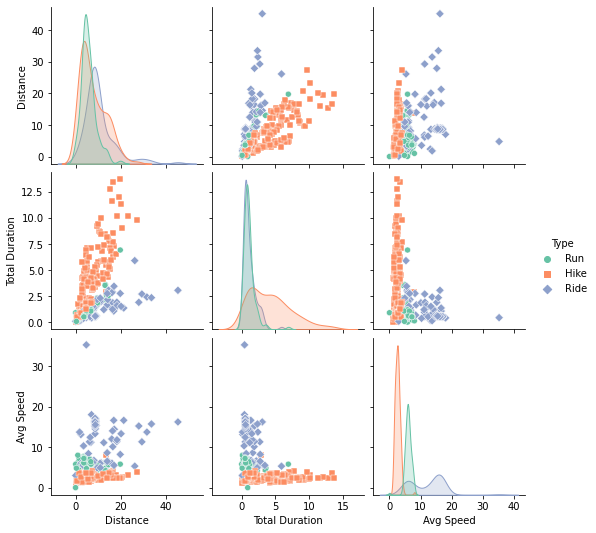

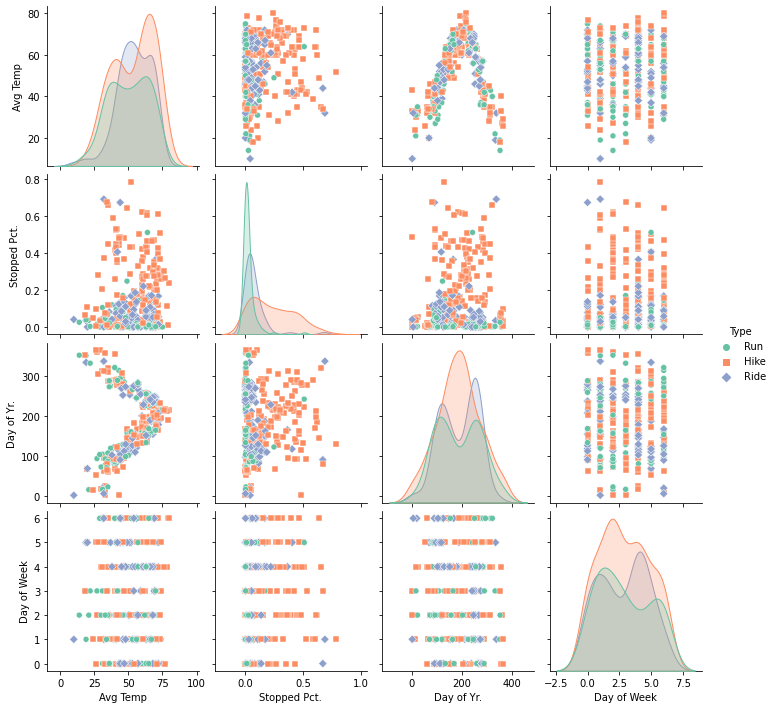

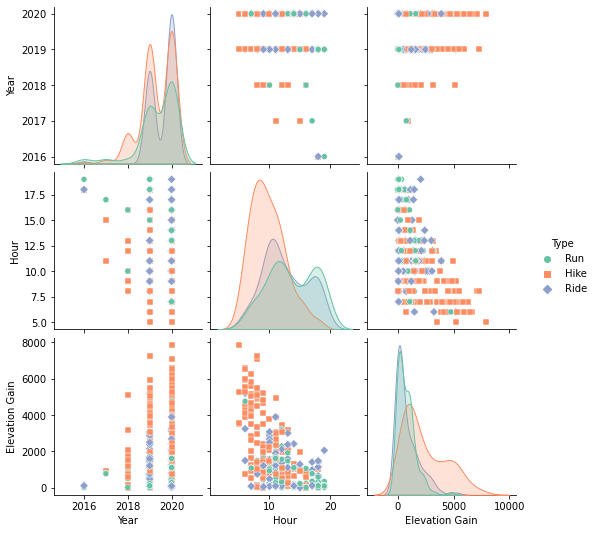

In [ ]:
#create a full dataset only for creating graphs below
full_dataset = clean_data(get_data(activities_path, weather_path))
full_dataset['day_of_week'] = data['Activity Date'].dt.dayofweek
full_dataset['day_of_year_y'] = data['Activity Date'].dt.dayofyear




def radar_chart(data):
    strava = data[['Type', 'Distance', 'Total Time', 'Avg Speed', 'Elevation Gain', 'stopped_pct']]
    strava.columns = ['Type', 'Distance', 'Total Time', 'Avg Speed', 'Elevation Gain', 'Stopped %']
    for i in list(strava)[1:]:
        maxi = max(strava[i])
        strava[i] = strava[i] / maxi
    df = pd.DataFrame(strava.groupby('Type').mean()).reset_index()
    dfmax = max(df.max(axis=1))
         
    # number of variable
    categories=list(df)[1:]
    N = len(categories)
     
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
     
    # Initialise the spider plot
    plt.figure(figsize=(7,7))
    ax = plt.subplot(111, polar=True)
     
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
     
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, fontweight='bold')
     
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([25, 50, 75], ["25","50","75"], color="grey", size=7)
    plt.ylim(0,dfmax)
     
     
    # ------- PART 2: Add plots
     
    # Plot each individual = each line of the data
    # I don't do a loop, because plotting more than 3 groups makes the chart unreadable
     
    # Ind1
    values=df.iloc[0].drop('Type').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="hike")
    ax.fill(angles, values, 'b', alpha=0.1)
     
    # Ind2
    values=df.iloc[1].drop('Type').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="bike")
    ax.fill(angles, values, 'r', alpha=0.1)
     
    
    #Ind3
    
    values=df.iloc[2].drop('Type').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="run")
    ax.fill(angles, values, 'g', alpha=0.1)
    
    # Add legend
    plt.legend(loc='lower center', bbox_to_anchor=(.95, 0.85))



radar_chart(full_dataset)


def correlogram(data):
    df = data.rename(columns={'Total Time': 'Total Duration', 'TAVG': 'Avg Temp', 'day_of_year_y': 'Day of Yr.', 'stopped_pct': 'Stopped Pct.',
                              'hour': 'Hour', 'day_of_week': 'Day of Week', 'year_y': 'Year'})
    df1 = df[['Type', 'Distance', 'Total Duration', 'Avg Speed']]
    df2 = df[['Type', 'Avg Temp', 'Stopped Pct.', 'Day of Yr.', 'Day of Week']]
    df3 = df[['Type', 'Year', 'Hour', 'Elevation Gain']]
    
    sns.pairplot(df1, kind="scatter", hue="Type", markers=["o", "s", "D"], palette="Set2")
    plt.show()
    sns.pairplot(df2, kind="scatter", hue="Type", markers=["o", "s", "D"], palette="Set2")
    plt.show()
    sns.pairplot(df3, kind="scatter", hue="Type", markers=["o", "s", "D"], palette="Set2")
    plt.show()
     
    
correlogram(full_dataset)


We can see a few interesting things from the visualizations:
- plotting the average speed histograms we can see the overlap between activity type. Based on speed alone, it would be hard to distinguish between bike rides and runs, and between fast hikes and slow runs. The bi-modal bike ride histogram likely corresponds to mountain bike rides (slower) and road bike rides (faster) 
- I tend to hike earlier in the day
- I take way fewer breaks while running than hiking or biking
- Most of my long activities with lots of elevation gain are hikes
- I am more likely to bike ride and run in the spring and fall
- my running trend and biking trends are very similar. I expect the model to have difficulty distinguishing between the two

## Scale data

To achieve better model performance, it is generally a good idea to scale the data so all features are in relatively similar units. This is not necessary for *all* of the models below, but it also likely won't hurt. The method below transforms each feature to have a mean of 0 and a standard deviation of 1. This also reduced the impact of outliers. If predicting the outliers is more important, scaling the features to percent of max (scikit-learn's MinMaxScaler class) may work better.

When using cross-validation, this method would lead to leakage between the training set and the kth fold since they were both scaled with the same metrics. Thus, you will see I use a pipeline with the scikit-learn scaler when using CV...

In [ ]:
def scale_data(train, test):
    # equivilent to the scikit-learn StandardScaler class. Takes metrics from train dataset to scale test set to prevent test data leakage
    train_scaled = copy.copy(train)
    test_scaled = copy.copy(test)
    means = []
    stds = []
    for i in train_scaled.columns:
        means.append(np.mean(train_scaled[i]))
        stds.append(np.std(train_scaled[i]))
    for i in  range(len(train_scaled.columns)):
        train_scaled.iloc[:,i] = (train_scaled.iloc[:,i] - means[i]) / stds[i]
        test_scaled.iloc[:,i] = (test_scaled.iloc[:,i] - means[i]) / stds[i]
    return test_scaled, train_scaled, means, stds


x_test_scaled, x_train_scaled, means, stds = scale_data(x_train_cleaned, x_test_cleaned)

# Model Fitting



## Run Baseline Models

Since every ML problem is different, you need to try many different types of models to decide which ones are worth your time to fine tune. Since the dataset is small, we don't have much in the way of computational constraints. Although accuracy is not the best evaluation metric for a lot of use cases, here it makes since becasue all we care about is 'inconveniencing' the user as little as possible by minimizing how often the model is wrong. There is no specific need for the model to be robust to outliers or under-represented activity types. 

In [ ]:
begin_time = datetime.now()

def get_models():
    # create a list of a bunch of classifiers to test as baselines. With this small of a datset, we have the computational ability to test 
    # a much higher proportion of the possible algorythm space to solve the problem. 
    models, model_names = list(), list()
    models.append(RidgeClassifier())
    model_names.append('Ridge')
    models.append(SVC())
    model_names.append('SVC')
    models.append(SGDClassifier())
    model_names.append('SGDC')
    models.append(KNeighborsClassifier(n_neighbors=3))
    model_names.append('KNC')
    models.append(GaussianProcessClassifier())
    model_names.append('GPC')
    models.append(RandomForestClassifier())
    model_names.append('RF')
    models.append(MLPClassifier(max_iter=200))
    model_names.append('MLP')
    models.append(LogisticRegression())
    model_names.append('LR')
    models.append(XGBClassifier())
    model_names.append('XG')
    return models, model_names

def evaluate_baselines():            
    # get a baseline accuracy of all the default params for the above classifiers, as well as the runtime. 
    cv = LeaveOneOut()
    models, model_names = get_models()                  
    baseline_results = []
    t = 0
    for i in range(len(models)):
        model_pipe = Pipeline(steps=[('scaler', StandardScaler()), (model_names[i], models[i])])
        baseline_score = cross_val_score(model_pipe, x_train_cleaned, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
        t = datetime.now() - begin_time
        baseline_results.append([model_names[i], round(np.mean(baseline_score), 2), t.seconds])
        print('finished running baseline: '+model_names[i])
    print('Total Runtime: ', datetime.now() - begin_time)
    for i in baseline_results:
        print(i)
    return baseline_results

baseline_results = evaluate_baselines()



finished running baseline: Ridge
finished running baseline: SVC
finished running baseline: SGDC
finished running baseline: KNC
finished running baseline: GPC
finished running baseline: RF
finished running baseline: MLP
finished running baseline: LR
finished running baseline: XG
Total Runtime:  0:02:32.176583
['Ridge', 0.86, 2]
['SVC', 0.91, 3]
['SGDC', 0.92, 5]
['KNC', 0.85, 5]
['GPC', 0.87, 24]
['RF', 0.97, 59]
['MLP', 0.92, 129]
['LR', 0.92, 134]
['XG', 0.97, 152]


## Pick Models to Tune

The results of the baseline models suggest that random forest, XGBoost, support vector machine, logistic regression and multi-layer perceptron models perform very well. Below we will fine tune hyperparameters for each of these. Logistic regression also preformed well but in my run was slightly less performant than the above list. 

My results were:<br>

['Ridge', 0.86, 6]<br>
['SVC', 0.91, 6]<br>
['SGDC', 0.91, 7]<br>
['KNC', 0.85, 7]<br>
['GPC', 0.87, 11]<br>
['RF', 0.97, 13]<br>
['MLP', 0.93, 25]<br>
['LR', 0.92, 25]<br>
['XG', 0.97, 31]<br>

Note: If the dataset was any larger, it would make since to use TensorFlow / Keras to build a neural network that can utilize GPU when processing. We will explore only a small amount of the hyperparamter space for the scikit-learn MLP classifier here. 
Also, due to the stochastic nature of many of these models and the small dataset size, your results may vary from mine! Also, I did a very coarse random search before choosing a narrower range of hyperparameters to search more intensively before I came up with these hyperparameter ranges.


## Random Forest Tuning

In [ ]:
begin_time = datetime.now()

def random_forest_tuning():
    # test different random forest hyperparameters
    model = RandomForestClassifier()
    model_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('rf', model)])
    rf_random_param_grid = {'n_estimators': [50],
                'max_depth': [int(i) for i in np.linspace(5, 60, num = 56)],
                'min_samples_split': [int(i) for i in np.linspace(2, 15, num = 14)],
                'min_samples_leaf': [int(i) for i in np.linspace(1, 5, num = 5)]}
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    
    search = RandomizedSearchCV(model_pipe, param_distributions=rf_random_param_grid, n_jobs=-1, n_iter=350, scoring='accuracy', cv=cv, return_train_score=True, verbose=2)
    search.fit(x_train_cleaned, y_train)
    random_forest_grid_results = search.cv_results_
    best_params = search.best_params_
    
    best_scores = pd.DataFrame({'scores': random_forest_grid_results['mean_test_score'], 'params': random_forest_grid_results['params']}).sort_values('scores', ascending=False).head(3)
    for row in range(len(best_scores['scores'])):
        print('Accuracy: '+str(round(best_scores.iloc[row,0], 2))+' '+str(best_scores.iloc[row,1]))
    return random_forest_grid_results, best_scores

random_forest_grid_results, random_best_scores = random_forest_tuning()

print('Runtime: ', datetime.now() - begin_time)

Fitting 15 folds for each of 350 candidates, totalling 5250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 718 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 1284 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2014 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2904 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3958 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 5172 tasks      | elapsed:  6.0min


Accuracy: 0.98 {'n_estimators': 50, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 25}
Accuracy: 0.98 {'n_estimators': 50, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 59}
Accuracy: 0.98 {'n_estimators': 50, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_depth': 60}
Runtime:  0:06:03.811027


[Parallel(n_jobs=-1)]: Done 5250 out of 5250 | elapsed:  6.1min finished


Your results may vary due to the random search of only a fraction of the parameter space, but in my run the top three fits performed no better than the default hyperparamters. taking an average of the top three results I got, the hyperparameters I will be using below are:

Accuracy: 0.971 {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 200}



## XGBoost Tuning



In [ ]:
begin_time = datetime.now()

def xg_boost_tuning():
    # test different xg boost hyperparameters
    model = XGBClassifier(use_label_encoder=False, eval_metric='merror')
    model_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('xg', model)])
    xg_param_grid = {'booster': ['gbtree', 'gblinear', 'dart'],
                     'eta': [0.001, 0.01, 0.1, 0.3, 0.5],
                     'gamma': [0, 0.01, 0.1, 0.5, 1, 2],
                     'max_depth': [int(i) for i in np.linspace(2, 60, num = 30)],
                     'lambda': [0.9, 1, 1.1, 1.5, 2, 3],
                     'alpha': [0.8, 0.9, 1, 1.1, 1.5, 2, 3]}

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    
    search = RandomizedSearchCV(model_pipe, param_distributions=xg_param_grid, n_iter=694, n_jobs=-1, scoring='accuracy', cv=cv, return_train_score=True, verbose=0)
    search.fit(x_train_cleaned, y_train)
    xg_boost_grid_results = search.cv_results_
    best_params = search.best_params_
    
    best_scores = pd.DataFrame({'scores': xg_boost_grid_results['mean_test_score'], 'params': xg_boost_grid_results['params']}).sort_values('scores', ascending=False).head(3)
    for row in range(len(best_scores['scores'])):
        print('Accuracy: '+str(round(best_scores.iloc[row,0], 2))+' '+str(best_scores.iloc[row,1]))
    return xg_boost_grid_results, best_scores



xg_boost_grid_results, xg_boost_best_scores = xg_boost_tuning()

print('Runtime: ', datetime.now() - begin_time)

Accuracy: 0.97 {'max_depth': 2, 'lambda': 1.1, 'gamma': 2, 'eta': 0.5, 'booster': 'gbtree', 'alpha': 1.5}
Accuracy: 0.97 {'max_depth': 6, 'lambda': 0.9, 'gamma': 1, 'eta': 0.3, 'booster': 'dart', 'alpha': 0.9}
Accuracy: 0.97 {'max_depth': 22, 'lambda': 3, 'gamma': 2, 'eta': 0.3, 'booster': 'dart', 'alpha': 0.9}
Runtime:  0:12:08.978229


Your results may vary due to the random search of only a fraction of the parameter space, but in my run the top three fits performed no better than the default hyperparamters. taking an average of the top three results I got, the hyperparameters I will be using below are:

Accuracy: 0.966 {'max_depth': 37, 'lambda': 1.67, 'gamma': 1, 'eta': 0.3, 'booster': 'dart', 'alpha': 0.8, 'merror': 'mlogloss'}

## SVC Tuning

In [ ]:
begin_time = datetime.now()
def svc_tuning():
    # test different SVC hyperparameters
    model = SVC()
    model_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('svc', model)])
    svc_random_param_grid = {'C': [i for i in np.linspace(start = 1.0, stop = 2.0, num = 10)],
                'kernel': ['linear'],
                'degree': [1, 2, 3],
                'gamma': ['scale', 'auto'],
                'coef0': [int(i) for i in np.linspace(start = 1, stop = 7, num = 7)],
                'shrinking': [True, False],
                'decision_function_shape': ['ovo']}

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    
    search = GridSearchCV(model_pipe, param_grid=svc_random_param_grid, n_jobs=-1, scoring='accuracy', cv=cv, return_train_score=True, verbose=2)
    search.fit(x_train_cleaned, y_train)
    svc_grid_results = search.cv_results_
    best_params = search.best_params_
    
    best_scores = pd.DataFrame({'scores': svc_grid_results['mean_test_score'], 'params': svc_grid_results['params']}).sort_values('scores', ascending=False).head(3)
    for row in range(len(best_scores['scores'])):
        print('Accuracy: '+str(round(best_scores.iloc[row,0], 2))+' '+str(best_scores.iloc[row,1]))
    return svc_grid_results, best_scores

svc_grid_results, svc_best_scores = svc_tuning()
print('Runtime: ', datetime.now() - begin_time)

Fitting 15 folds for each of 840 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 2348 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 5596 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 10124 tasks      | elapsed:   57.0s


Accuracy: 0.95 {'C': 1.4444444444444444, 'coef0': 1, 'decision_function_shape': 'ovo', 'degree': 1, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True}
Accuracy: 0.95 {'C': 1.4444444444444444, 'coef0': 5, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 'auto', 'kernel': 'linear', 'shrinking': True}
Accuracy: 0.95 {'C': 1.4444444444444444, 'coef0': 6, 'decision_function_shape': 'ovo', 'degree': 1, 'gamma': 'auto', 'kernel': 'linear', 'shrinking': False}
Runtime:  0:01:11.630374


[Parallel(n_jobs=-1)]: Done 12600 out of 12600 | elapsed:  1.2min finished


Your results may vary due to the random search of only a fraction of the parameter space, but in my run the top three fits performed 3% better than the default hyperparamters. taking an average of the top three results I got, the hyperparameters I will be using below are:

Accuracy: 0.944 {'C': 1.222, 'coef0': 4, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': False, 'probability': True}

## MLP Tuning

In [ ]:
begin_time = datetime.now()
def mlp_tuning():
    # test different random forest hyperparameters. NOTE: if you really want to customize MLP beyond what you see here or for a larger dataset, use Keras / TF !
    model = MLPClassifier()
    model_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('mlp', model)])
    mlp_random_param_grid = {'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100), (50, 25, 12, 6), (50,), (25,), (100, 25), (100, 50)],
                'activation': ['logistic'],
                'solver': ['lbfgs'],
                'alpha': [i for i in np.linspace(start = 0.0001, stop = 0.5, num = 10)],
                'learning_rate': ['constant', 'invscaling', 'adaptive'],
                'max_iter': [200],
                'tol': [0.0001]}
                #'early_stopping': [True]}

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    
    search = GridSearchCV(model_pipe, param_grid=mlp_random_param_grid, error_score=0, n_jobs=-1, scoring='accuracy', cv=cv, return_train_score=True, verbose=2)
    search.fit(x_train_cleaned, y_train)
    mlp_grid_results = search.cv_results_
    best_params = search.best_params_
    
    best_scores = pd.DataFrame({'scores': mlp_grid_results['mean_test_score'], 'params': mlp_grid_results['params']}).sort_values('scores', ascending=False).head(3)
    for row in range(len(best_scores['scores'])):
        print('Accuracy: '+str(round(best_scores.iloc[row,0], 2))+' '+str(best_scores.iloc[row,1]))
    return mlp_grid_results, best_scores


mlp_grid_results, mlp_best_scores = mlp_tuning()
print('Runtime: ', datetime.now() - begin_time)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 15 folds for each of 240 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 244 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 561 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 844 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1312 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1852 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 2497 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 3220 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 19.1min finished


Accuracy: 0.97 {'activation': 'logistic', 'alpha': 0.22227777777777777, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'invscaling', 'max_iter': 200, 'solver': 'lbfgs', 'tol': 0.0001}
Accuracy: 0.97 {'activation': 'logistic', 'alpha': 0.22227777777777777, 'hidden_layer_sizes': (100, 25), 'learning_rate': 'invscaling', 'max_iter': 200, 'solver': 'lbfgs', 'tol': 0.0001}
Accuracy: 0.97 {'activation': 'logistic', 'alpha': 0.2778222222222222, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'adaptive', 'max_iter': 200, 'solver': 'lbfgs', 'tol': 0.0001}
Runtime:  0:19:10.721977


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Your results may vary due to the random search of only a fraction of the parameter space, but in my run the top three fits performed 3% better than the default hyperparamters. taking an average of the top three results I got, the hyperparameters I will be using below are:

Accuracy: 0.965 {'activation': 'logistic', 'alpha': 0.1852, 'hidden_layer_sizes': (100, 100, 100), 'max_iter': 1000, 'solver': 'lbfgs', 'tol': 0.0001}

## Logistic Regression Tuning

In [ ]:
begin_time = datetime.now()
def lr_tuning():
    model = LogisticRegression()
    model_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('lr', model)])
    lr_random_param_grid = {'penalty': ['l1', 'l2'],
                'C': np.logspace(-4, 4, 30),
                'fit_intercept': [True, False],
                'solver': ['liblinear']}
                

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
    
    search = GridSearchCV(model_pipe, param_grid=lr_random_param_grid, error_score=0, n_jobs=-1, scoring='accuracy', cv=cv, return_train_score=True, verbose=2)
    search.fit(x_train_cleaned, y_train)
    lr_grid_results = search.cv_results_
    best_params = search.best_params_
    
    best_scores = pd.DataFrame({'scores': lr_grid_results['mean_test_score'], 'params': lr_grid_results['params']}).sort_values('scores', ascending=False).head(3)
    for row in range(len(best_scores['scores'])):
        print('Accuracy: '+str(round(best_scores.iloc[row,0], 2))+' '+str(best_scores.iloc[row,1]))
    return lr_grid_results, best_scores

lr_grid_results, lr_best_scores = lr_tuning()
print('Runtime: ', datetime.now() - begin_time)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 25 folds for each of 120 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done 668 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 2624 tasks      | elapsed:   28.2s


Accuracy: 0.93 {'C': 17.433288221999874, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.93 {'C': 9.236708571873866, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.93 {'C': 4.893900918477489, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}
Runtime:  0:00:49.786763


[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   49.7s finished


Your results may vary due to the random search of only a fraction of the parameter space, but in my run the top three fits performed 1% better than the default hyperparamters. taking an average of the top three results I got, the hyperparameters I will be using below are:

Accuracy: 0.93 {'C': 10.52, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}

## Visualize Tuned Model Results

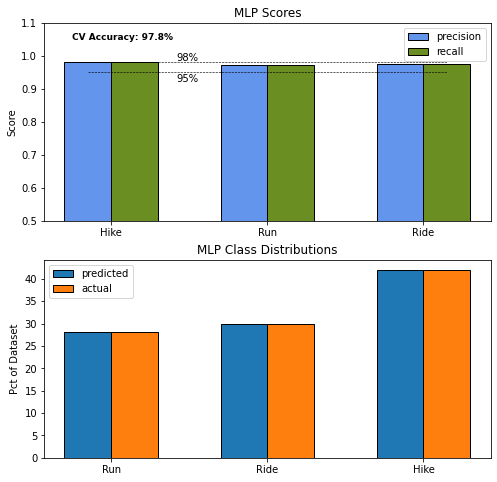

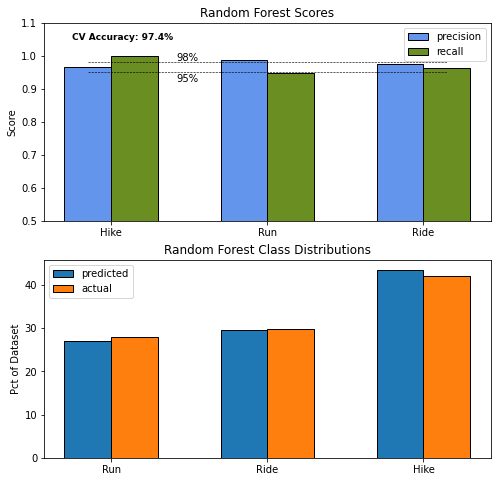

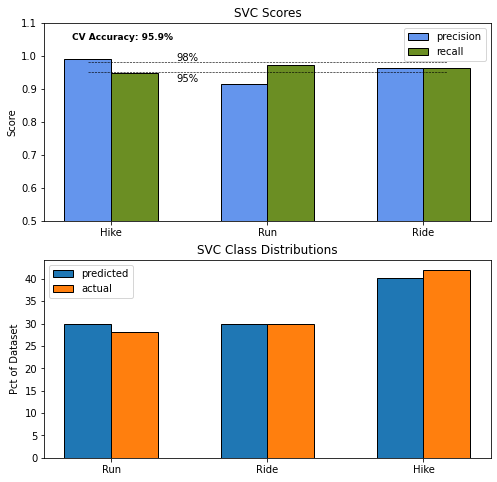

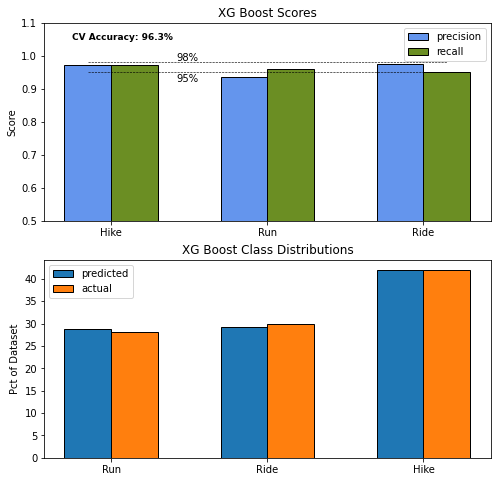

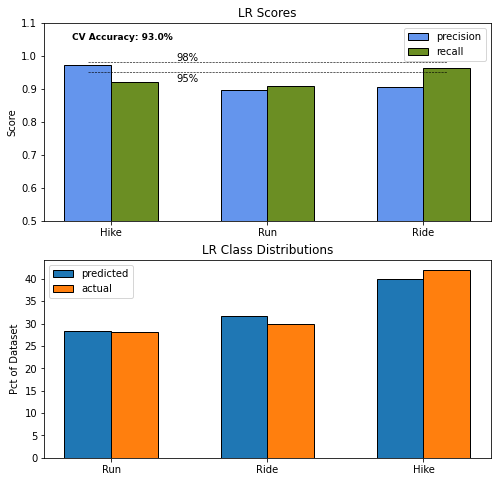

Runtime:  0:01:07.400003


In [ ]:

begin_time = datetime.now()

# I manually averaged the best hyperperameters from the best 3 performing models for each hyperparameter search:
mlp_params = {'activation': 'logistic', 'alpha': 0.1852, 'hidden_layer_sizes': (100, 100, 100), 'max_iter': 1000, 'solver': 'lbfgs', 'tol': 0.0001}
rf_params = {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 200}
xg_params = {'max_depth': 37, 'lambda': 1.67, 'gamma': 1, 'eta': 0.3, 'booster': 'dart', 'alpha': 0.8, 'merror': 'mlogloss'}
svc_params = {'C': 1.222, 'coef0': 4, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': False, 'probability': True}
lr_params = {'C': 10.52, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}

def compare_tuned_models(x_train, y_train, mlp_params, rf_params, xg_params, svc_params, lr_params):
    
    models = {'MLP': MLPClassifier(**mlp_params), 'Random Forest': RandomForestClassifier(**rf_params), 'SVC': SVC(**svc_params), 'XG Boost': XGBClassifier(**xg_params), 'LR': LogisticRegression(**lr_params)}
    results = pd.DataFrame(columns=['Classifier', 'Scores'])
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
    # for each model, fit it and output some graphs to see how the model is performing more specifically 
    for key, value in models.items():
        model_pipe = Pipeline(steps=[('scaler', StandardScaler()), (key, value)])
        y_pred = cross_val_predict(model_pipe, x_train, y_train, cv=5)
        report = classification_report(y_train, y_pred, labels = [0, 1, 2], target_names = ['Run', 'Ride', 'Hike'], output_dict=True)      
        results = results.append({'Classifier': key, 
                              'Scores': cross_val_score(model_pipe, x_train_cleaned, y_train, cv=cv, n_jobs=-1, scoring='accuracy')}, 
                             ignore_index=True)
        # figure 1: precision and recall for each activity type
        plt.figure(figsize=(8,8))
        plt.subplot(211)
        # width of the bars
        barWidth = 0.3
         
        bars1 = [report['Hike']['precision'], report['Run']['precision'], report['Ride']['precision']]
        bars2 = [report['Hike']['recall'], report['Run']['recall'], report['Ride']['recall']]
         
        # create a numerical x axis to place labels and bars on
        r1 = np.arange(len(bars1))
        r2 = [x + barWidth for x in r1]
        r3 = np.append(r1, r2)
        plt.bar(r1, bars1, width = barWidth, color = 'cornflowerblue', edgecolor = 'black', capsize=7, label='precision')
        plt.bar(r2, bars2, width = barWidth, color = 'olivedrab', edgecolor = 'black', capsize=7, label='recall')
        
        plt.text(-.1, 1.05, r'CV Accuracy: '+str(round(report['accuracy']*100, 1))+'%', fontsize=9, fontweight='bold')
        plt.xticks([r + (barWidth / 2) for r in range(len(bars1))], ['Hike', 'Run', 'Ride'])
        plt.ylabel('Score')
        plt.ylim([0.5, 1.1])
        
        label = [bars1[0], bars2[0], bars1[1], bars2[1], bars1[2], bars2[2]]
        plt.title(str(key)+' Scores')
        plt.legend()
        
        plt.hlines(0.95, xmin=min(r3), xmax=max(r3), color='black', linestyles='dashed', label='95%', linewidth=0.6)
        plt.hlines(0.98, xmin=min(r3), xmax=max(r3), color='black', linestyles='dashed', label='98%', linewidth=0.6)
        plt.text(0.57, 0.995, '98%', ha='left', va='center')
        plt.text(0.57, 0.93, '95%', ha='left', va='center')
        
        
        # figure 2: class distribution from predictions and train dataset as a whole
        
        
        plt.subplot(212)
        
        predicted_dist = [(y_pred == 0).sum() / len(y_train) *100, (y_pred == 1).sum() / len(y_train) *100, (y_pred == 2).sum() / len(y_train) *100]
        
        actual_dist = [(y_train == 0).sum() / len(y_train) *100, (y_train == 1).sum() / len(y_train) *100, (y_train == 2).sum() / len(y_train) *100]
        
        barWidth = 0.3
         
        bars1 = predicted_dist
        bars2 = actual_dist
         
        r1 = np.arange(len(bars1))
        r2 = [x + barWidth for x in r1]

        plt.bar(r1, bars1, width = barWidth, color = 'tab:blue', edgecolor = 'black', capsize=7, label='predicted')
        plt.bar(r2, bars2, width = barWidth, color = 'tab:orange', edgecolor = 'black', capsize=7, label='actual')
        
        plt.xticks([r + (barWidth / 2) for r in range(len(bars1))], ['Run', 'Ride', 'Hike'])
        plt.ylabel('Pct of Dataset')
        plt.legend()
        plt.title(key+' Class Distributions')
        
        
        plt.show()
    # since we generated cross-val scores above, the models were fit on different partitions. Thus I refit them here and same them locally
    dump(MLPClassifier(**mlp_params).fit(x_train_scaled, y_train), 'mlp_tuned.joblib')
    dump(RandomForestClassifier(**rf_params).fit(x_train_scaled, y_train), 'rf_tuned.joblib')
    dump(SVC(**svc_params).fit(x_train_scaled, y_train), 'svc_tuned.joblib')
    dump(XGBClassifier(**xg_params).fit(x_train_scaled, y_train), 'xg_tuned.joblib')
    
    return results


results = compare_tuned_models(x_train_cleaned, y_train, mlp_params, rf_params, xg_params, svc_params, lr_params)

print('Runtime: ', datetime.now() - begin_time)



These charts show that none of the models are under or over-representing any of the activity classes in their predictions. The recall and precision values for each class are very similar, which is very good.

Precision can be interpereted as: when the model guesses 'run', it is correct 98% of the time. 
Recall can be interpereted as: 95% of 'runs' were classified correctly.  

## Building Some Ensembles

Ensembles are estimators built from multiple other estimators. There are three main categories of ensembles; voting, stacking, and bagging ensembles. 

- Voting classifiers simply take in a list of input models, and each sub-model gets a vote as to what the class of each x vector. This can be hard or soft voting; in hard voting, each sub-model gets '1' vote. In soft voting, the votes are weighted by how confident each sub-model is of the class it voted. Highly confident models get higher vote. However, input models to soft voting ensembles should be calibrated before thier output probabilities can be used in this manner. 

- Stacking classifiers take in a list of sub-models and feed predictions through from one to another. This, in theory, can improve accuracy because one model can focus on the mistakes of the previous model, rather than trying to learn all patterns in the dataset. In theory, the more different your models are, the better gains you will see with ensembling. 

- Bagging classifiers split the dataset into chunks and build parallel models on each chunk. Then the fitted sub-models vote on the class of each x vector. 

XGBoost and random forest are similar models, so I will just test random forest in my ensembles in this case. Feel free to play around with XGBoost if you please. Ensembling often sounds too good to be true! Well, it often is. It is not unusual for any of these ensemble methods to perform no better or sometimes worse than a single model. 



In [ ]:

begin_time = datetime.now()

def build_ensemble(x_train, y_train, results, mlp_params, rf_params, xg_params, svc_params, lr_params):
    
    models = {'MLP': MLPClassifier(**mlp_params), 'Random Forest': RandomForestClassifier(**rf_params), 'SVC': SVC(**svc_params), 'LR': LogisticRegression(**lr_params)}
    # create 6 ensembles
    voting_classifier_hard = VotingClassifier(estimators=[('MLP', models['MLP']), ('Random Forest', models['Random Forest']), ('SVC', models['SVC']), ('LR', models['LR'])], voting='hard')
    voting_classifier_soft = VotingClassifier(estimators=[('MLP', models['MLP']), ('Random Forest', models['Random Forest']), ('SVC', models['SVC']), ('LR', models['LR'])], voting='soft')
    
    stacking_classifier = StackingClassifier(estimators=[('MLP', models['MLP']), ('Random Forest', models['Random Forest']), ('SVC', models['SVC'])], final_estimator=LogisticRegression())
    
    mlp_bagging_classifier = BaggingClassifier(base_estimator=MLPClassifier(**mlp_params), n_estimators=50, random_state=42)
    svc_bagging_classifier = BaggingClassifier(base_estimator=SVC(**svc_params), n_estimators=50, random_state=42)
    rf_bagging_classifier = BaggingClassifier(base_estimator=RandomForestClassifier(**rf_params), n_estimators=50, random_state=42)
    lr_bagging_classifier = BaggingClassifier(base_estimator=LogisticRegression(**lr_params), n_estimators=50, random_state=42)
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
    
    vc_pipe_h = Pipeline(steps=[('scaler', StandardScaler()), ('voting_classifier_hard', voting_classifier_hard)])
    vc_pipe_s = Pipeline(steps=[('scaler', StandardScaler()), ('voting_classifier_soft', voting_classifier_soft)])
    mlp_b = Pipeline(steps=[('scaler', StandardScaler()), ('mlp_bagging_classifier', mlp_bagging_classifier)])
    svc_b = Pipeline(steps=[('scaler', StandardScaler()), ('svc_bagging_classifier', svc_bagging_classifier)])
    rf_b = Pipeline(steps=[('scaler', StandardScaler()), ('rf_bagging_classifier', rf_bagging_classifier)])
    lr_b = Pipeline(steps=[('scaler', StandardScaler()), ('lr_bagging_classifier', lr_bagging_classifier)])   
    stacking = Pipeline(steps=[('scaler', StandardScaler()), ('stacking_classifier', stacking_classifier)])
    # get cross-val scores on the ensembles and save them in the same dataframe as above

    results = results.append({'Classifier': 'voting_classifier_hard', 
                              'Scores':cross_val_score(vc_pipe_h, x_train, y_train, cv=cv, n_jobs=-1, scoring='accuracy')}, 
                             ignore_index=True)
    results = results.append({'Classifier': 'voting_classifier_soft', 
                              'Scores':cross_val_score(vc_pipe_s, x_train, y_train, cv=cv, n_jobs=-1, scoring='accuracy')}, 
                             ignore_index=True)
    results = results.append({'Classifier': 'stacking_classifier', 
                              'Scores':cross_val_score(stacking, x_train, y_train, cv=cv, n_jobs=-1, scoring='accuracy')}, 
                             ignore_index=True)
    results = results.append({'Classifier': 'mlp_bagging_classifier', 
                              'Scores':cross_val_score(mlp_b, x_train, y_train, cv=cv, n_jobs=-1, scoring='accuracy')}, 
                             ignore_index=True)
    results = results.append({'Classifier': 'svc_bagging_classifier', 
                              'Scores':cross_val_score(svc_b, x_train, y_train, cv=cv, n_jobs=-1, scoring='accuracy')}, 
                             ignore_index=True)
    results = results.append({'Classifier': 'rf_bagging_classifier', 
                              'Scores':cross_val_score(rf_b, x_train, y_train, cv=cv, n_jobs=-1, scoring='accuracy')}, 
                             ignore_index=True)
    results = results.append({'Classifier': 'lr_bagging_classifier', 
                              'Scores':cross_val_score(lr_b, x_train, y_train, cv=cv, n_jobs=-1, scoring='accuracy')}, 
                             ignore_index=True)
    
    
    for row in range(len(results['Scores'])):
        results.loc[row, 'Mean Score'] = np.mean(results.loc[row, 'Scores'])
    # refit and save the models on the whole train dataset
    dump(voting_classifier_hard.fit(x_train_scaled, y_train), 'voting_classifier_hard.joblib')
    dump(voting_classifier_soft.fit(x_train_scaled, y_train), 'voting_classifier_soft.joblib')
    dump(stacking_classifier.fit(x_train_scaled, y_train), 'stacking_classifier.joblib')
    dump(mlp_bagging_classifier.fit(x_train_scaled, y_train), 'mlp_bagging_classifier.joblib')
    dump(svc_bagging_classifier.fit(x_train_scaled, y_train), 'svc_bagging_classifier.joblib')
    dump(rf_bagging_classifier.fit(x_train_scaled, y_train), 'rf_bagging_classifier.joblib')
    dump(lr_bagging_classifier.fit(x_train_scaled, y_train), 'lr_bagging_classifier.joblib')
    
    return results

results = build_ensemble(x_train_scaled, y_train, results, mlp_params, rf_params, xg_params, svc_params, lr_params)
print('Runtime: ', datetime.now() - begin_time)

Runtime:  0:36:10.533390


In my results, the ensembles didn't do worse than all of the tuned single models, but the improvements were small. Since inference will occur on a smartphone, it may be best to pick the best, simplest model. In that case, I would choose SVC or random forest. Here are my results:

| Classifier               | Mean Score |
| ------------------------ | ---------- |
| MLP                      | 0.965      |
| Random Forest            | 0.971      |
| SVC                      | 0.944      |
| XG Boost                 | 0.966      |
| LR                       | 0.927      |
| voting\_classifier\_hard | 0.965      |
| voting\_classifier\_soft | 0.965      |
| stacking\_classifier     | 0.971      |
| mlp\_bagging\_classifier | 0.960      |
| svc\_bagging\_classifier | 0.956      |
| rf\_bagging\_classifier  | 0.976      |
| lr\_bagging\_classifier  | 0.936      |

## Select Final Model



0.9399460188933874


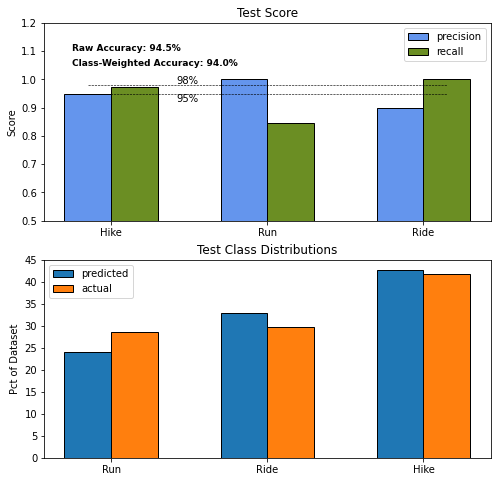

In [ ]:
def choose_final_model(x_test, y_test, x_train, y_train, results):
    # choose the best model, reload it, and see how it does on the test dataset! Not too bad: a slight overfit in the selected model but 
    # that is hard to avoid on a small dataset like this.
    model = load('rf_tuned.joblib')
    
    y_pred = model.predict(x_test)    

    score = balanced_accuracy_score(y_test, y_pred)
    results = results.append({'Classifier': 'RF Final', 'Test Score': score}, ignore_index=True)
    results.to_csv('model_results.csv')
    print(score)
    report = classification_report(y_test, y_pred, labels = [0, 1, 2], target_names = ['Run', 'Ride', 'Hike'], output_dict=True)      

    # figure 1: precision and recall for each activity type
    plt.figure(figsize=(8,8))
    plt.subplot(211)
    # width of the bars
    barWidth = 0.3
     
    bars1 = [report['Hike']['precision'], report['Run']['precision'], report['Ride']['precision']]
    bars2 = [report['Hike']['recall'], report['Run']['recall'], report['Ride']['recall']]
     
    # create a numerical x axis to place labels and bars on
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3 = np.append(r1, r2)
    plt.bar(r1, bars1, width = barWidth, color = 'cornflowerblue', edgecolor = 'black', capsize=7, label='precision')
    plt.bar(r2, bars2, width = barWidth, color = 'olivedrab', edgecolor = 'black', capsize=7, label='recall')
    
    plt.text(-.1, 1.1, r'Raw Accuracy: '+str(round(report['accuracy']*100, 1))+'%', fontsize=9, fontweight='bold')
    plt.text(-.1, 1.05, r'Class-Weighted Accuracy: '+str(round(score*100, 1))+'%', fontsize=9, fontweight='bold')
    plt.xticks([r + (barWidth / 2) for r in range(len(bars1))], ['Hike', 'Run', 'Ride'])
    plt.ylabel('Score')
    plt.ylim([0.5, 1.2])
    
    label = [bars1[0], bars2[0], bars1[1], bars2[1], bars1[2], bars2[2]]
    plt.title('Test Score')
    plt.legend(loc=1)
    
    plt.hlines(0.95, xmin=min(r3), xmax=max(r3), color='black', linestyles='dashed', label='95%', linewidth=0.6)
    plt.hlines(0.98, xmin=min(r3), xmax=max(r3), color='black', linestyles='dashed', label='98%', linewidth=0.6)
    plt.text(0.57, 0.995, '98%', ha='left', va='center')
    plt.text(0.57, 0.93, '95%', ha='left', va='center')
    
    # figure 2: class distribution from predictions and test dataset as a whole
    
    plt.subplot(212)
    
    predicted_dist = [(y_pred == 0).sum() / len(y_test) *100, (y_pred == 1).sum() / len(y_test) *100, (y_pred == 2).sum() / len(y_test) *100]
    
    actual_dist = [(y_test == 0).sum() / len(y_test) *100, (y_test == 1).sum() / len(y_test) *100, (y_test == 2).sum() / len(y_test) *100]
    
    barWidth = 0.3
     
    bars1 = predicted_dist
    bars2 = actual_dist
     
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    
    plt.bar(r1, bars1, width = barWidth, color = 'tab:blue', edgecolor = 'black', capsize=7, label='predicted')
    plt.bar(r2, bars2, width = barWidth, color = 'tab:orange', edgecolor = 'black', capsize=7, label='actual')
    
    plt.xticks([r + (barWidth / 2) for r in range(len(bars1))], ['Run', 'Ride', 'Hike'])
    plt.ylabel('Pct of Dataset')
    plt.legend()
    plt.title('Test Class Distributions')
    return y_pred


test_predictions = choose_final_model(x_test_scaled, y_test, x_train_scaled, y_train, results)

My result is 94%. Not bad. There was a bit of overfitting since the test score is lower than train score, but this is hard to avoid on such a small dataset. We have a model that meets our needs!

##Make Some Predictions
luckily for us, I have a few weeks worth of activities we can try out the new model to make sure we didn't skrew something up.

In [ ]:
new_activities_path = 'https://raw.githubusercontent.com/bimewok/Strava-Classifier/main/data/ActivityDetails12_14_2020.csv'
new_weather_path = 'https://raw.githubusercontent.com/bimewok/Strava-Classifier/main/data/weather12_14_2020.csv'



def get_prediction_new_data(new_activities_path, new_weather_path, means, stds):
    data = get_data(new_activities_path, new_weather_path)
    x = data.drop(['Type', 'Activity Name', 'Activity ID'], axis=1)
    y = data['Type'].map({'Run': 0, 'Ride': 1, 'Hike': 2})
    x = clean_data(x)
    for i in  range(len(x.columns)):
        x.iloc[:,i] = (x.iloc[:,i] - means[i]) / stds[i]
    model = load('rf_tuned.joblib')
    
    y_pred = model.predict(x)    

    score = balanced_accuracy_score(y, y_pred)
    
    print('Accuracy: '+str(score))
    return y_pred, x

begin_time = datetime.now()
new_predictions, new_x = get_prediction_new_data(new_activities_path, new_weather_path, means, stds)
print('Runtime: ', datetime.now() - begin_time)

Accuracy: 1.0
Runtime:  0:00:00.690394


#Conclusion

The predictions on 16 new activities were all correct! This doesn't mean the model is 100% accurate, of course, but that is encouraging nonetheless. Additionally, the model ran in 1/2 seconds, which is totally manageable on a smartphone. Your results may vary. The model JOBLIB file is half a megabyte, which is also reasonable. 